In [1]:
%matplotlib inline
from collections import defaultdict
import h5py
import numpy as np
import os

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)

from biosppy.signals import ecg
import pandas as pd

# IPython imports
from IPython.display import Image

In [2]:
from ml4cvd.tensor_generators import test_train_valid_tensor_generators, get_test_train_valid_paths, TensorGenerator
from ml4cvd.tensor_maps_by_hand import TMAPS
from ml4cvd.arguments import _get_tmap

tm_ramp = _get_tmap('ecg_rest_ramplitude')
tm_samp = _get_tmap('ecg_rest_samplitude')
tm_ecg_rest_raw = _get_tmap('ecg_rest_raw')
tm_ecg_median_raw = _get_tmap('ecg_rest_median_raw')
tm_ecg_lvh_avl = _get_tmap('ecg_rest_lvh_avl')
tm_ecg_lvh_sokolow_lyon = _get_tmap('ecg_rest_lvh_sokolow_lyon')
tm_ecg_lvh_cornell = _get_tmap('ecg_rest_lvh_cornell')
tm_la_enlargement = _get_tmap('left_atrial_enlargement')
train_paths, valid_paths, test_paths = get_test_train_valid_paths('/home/pdiachil/ecg_amp_merged//', 0.1, 0.1, 10)

/usr/local/lib/python3.6/dist-packages/apache_beam/__init__.py:84: UserWarning: Running the Apache Beam SDK on Python 3 is not yet fully supported. You may encounter buggy behavior or missing features.
  'Running the Apache Beam SDK on Python 3 is not yet fully supported. '
Using TensorFlow backend.


In [7]:
import h5py
df_dic = {'patient_id': [], 'sex': [], 'LVH': [], 'aVL': [], 'Sokolow_Lyon': [], 'Cornell': [],
         'full_path': [], 'ecg_text': []}
for train_path in train_paths:
    df_dic['patient_id'].append(train_path.split('/')[-1])
    df_dic['LVH'].append(0.0)
    df_dic['aVL'].append(0.0)
    df_dic['Sokolow_Lyon'].append(0.0)
    df_dic['Cornell'].append(0.0)
    df_dic['full_path'].append(train_path)
    ff = h5py.File(train_path, 'r')
    sex = 'male'
    if 'Genetic-sex_Female_0_0' in ff['categorical']:
        sex='female'
    df_dic['sex'].append(sex)   
    df_dic['ecg_text'].append(ff['ecg_rest_text'][0])
    if 'Left ventricular hypertrophy' in ff['ecg_rest_text'][0]: 
        df_dic['LVH'][-1] = 1.0
        #Hyp
        try:
            in_lvh_avl = tm_ecg_lvh_avl.tensor_from_file(tm_ecg_lvh_avl, ff)
            in_lvh_sokolow_lyon = tm_ecg_lvh_sokolow_lyon.tensor_from_file(tm_ecg_lvh_sokolow_lyon, ff)
            in_lvh_cornell = tm_ecg_lvh_cornell.tensor_from_file(tm_ecg_lvh_cornell, ff)
            if in_lvh_avl[1] > 0.5 : df_dic['aVL'][-1] = 1.0
            if in_lvh_sokolow_lyon[1] > 0.5 : df_dic['Sokolow_Lyon'][-1] = 1.0
            if in_lvh_cornell[1] > 0.5 : df_dic['Cornell'][-1] = 1.0
        except ValueError:
            'Sex'
    ff.close()
df = pd.DataFrame(df_dic)

In [8]:
def get_ecg_traces(train_path):
    ff = h5py.File(train_path, 'r')
    in_ecg  = tm_ecg_rest_raw.tensor_from_file(tm_ecg_rest_raw, ff, {})*2000.0
    in_ecg_median = tm_ecg_rest_raw.tensor_from_file(tm_ecg_median_raw, ff, {})*2000.0
    in_ramp = tm_ramp.tensor_from_file(tm_ramp, ff)
    in_samp = tm_samp.tensor_from_file(tm_samp, ff)
    in_la_enlargement = tm_la_enlargement.tensor_from_file(tm_la_enlargement, ff) 

    leads = {}
    for field in tm_ecg_rest_raw.channel_map:
        leads[field] = list(in_ecg[:, tm_ecg_rest_raw.channel_map[field]])
    
    twelve_leads = defaultdict(dict)
    for key, data in leads.items():        
        if len(data) == 5000:
            twelve_leads[key]['raw'] = leads[key]
            (twelve_leads[key]['ts_reference'], twelve_leads[key]['filtered'], twelve_leads[key]['rpeaks'], 
             twelve_leads[key]['template_ts'], twelve_leads[key]['templates'], twelve_leads[key]['heart_rate_ts'], 
             twelve_leads[key]['heart_rate']) = ecg.ecg(signal=leads[key], 
                                                        sampling_rate = 500.,
                                                        show=False)
    return twelve_leads

# Plot ECG
%matplotlib inline
from matplotlib import rcParams
rcParams['font.size'] = 24
def plot_traces(twelve_leads):
    # plot will be in seconds vs mV, boxes are 
    sec_per_box = 0.04
    mv_per_box = .1
    time_interval = 2.5 # time-interval per plot in seconds. ts_Reference data is in s, voltage measurement is 5 uv per lsb
    raw_scale = 0.005 # convert to mV

    fig, ax = plt.subplots(nrows=3, ncols=4, sharey='row', figsize=(24,18), tight_layout=True)
    lead_mapping = np.array([['strip_I','strip_aVR', 'strip_V1', 'strip_V4'],
                  ['strip_II','strip_aVL', 'strip_V2', 'strip_V5'],
                  ['strip_III','strip_aVF', 'strip_V3', 'strip_V6'],
                 ])

    for i in range(0,3):
        for j in range(0,4):
            lead_name = lead_mapping[i,j]
            lead = twelve_leads[lead_name]
            ax[i,j].set_xlim(j*time_interval,(j+1)*time_interval)
            ax[i,j].set_ylim(-1.5, 1.5) # -1.5mV -> 1.5mV
            ax[i,j].xaxis.set_major_locator(MultipleLocator(0.4)) # major grids at every .2sec = 5 * 0.04 sec
            ax[i,j].yaxis.set_major_locator(MultipleLocator(0.5)) # major grids at every .5mV 

            ax[i,j].xaxis.set_minor_locator(AutoMinorLocator(5))
            ax[i,j].yaxis.set_minor_locator(AutoMinorLocator(5))

            ax[i,j].grid(which='major', color='#CCCCCC', linestyle='--')
            ax[i,j].grid(which='minor', color='#CCCCCC', linestyle=':')
        
            #normalize data in muv
            #ax[i,j].plot(lead['ts_reference'], [elem_ * raw_scale for elem_ in lead['filtered']], label='filtered')
            ax[i,j].plot(lead['ts_reference'], [elem_ * raw_scale for elem_ in lead['raw']], label='raw')
            ax[i,j].set_title(lead_name)
            ax[0,0].legend(loc='lower right')

# aVL Criterion

patient_id                                            3377223.hd5
sex                                                        female
LVH                                                             1
aVL                                                             1
Sokolow_Lyon                                                    0
Cornell                                                         0
full_path              /home/pdiachil/ecg_amp_merged//3377223.hd5
ecg_text        Normal sinus rhythm Left ventricular hypertrop...
Name: 151, dtype: object

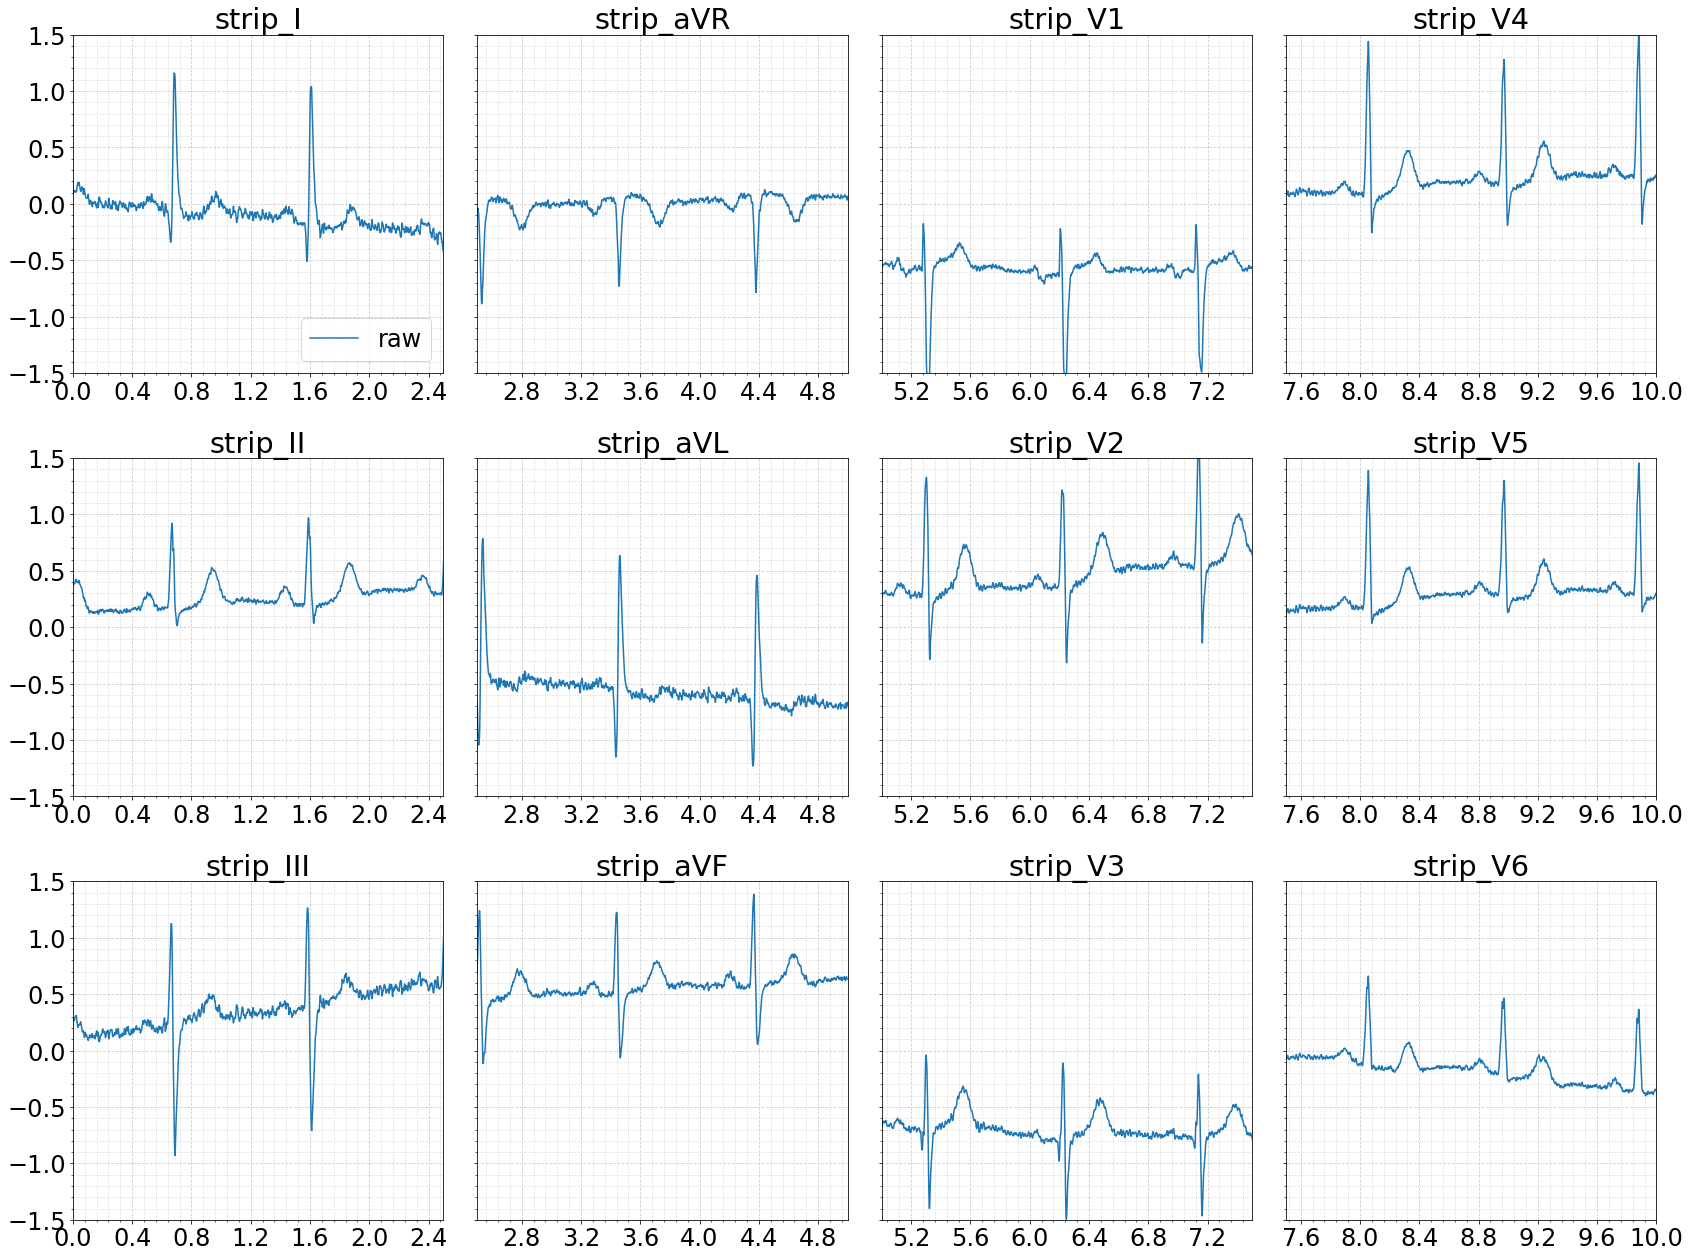

In [9]:
pp = df[df['aVL']>0.5].iloc[0]
avl_traces = get_ecg_traces(pp['full_path'])
plot_traces(avl_traces)
pp

# Sokolow-Lyon Criterion

patient_id                                            1110106.hd5
sex                                                          male
LVH                                                             1
aVL                                                             0
Sokolow_Lyon                                                    1
Cornell                                                         0
full_path              /home/pdiachil/ecg_amp_merged//1110106.hd5
ecg_text        Marked sinus bradycardia Possible Left atrial ...
Name: 35, dtype: object

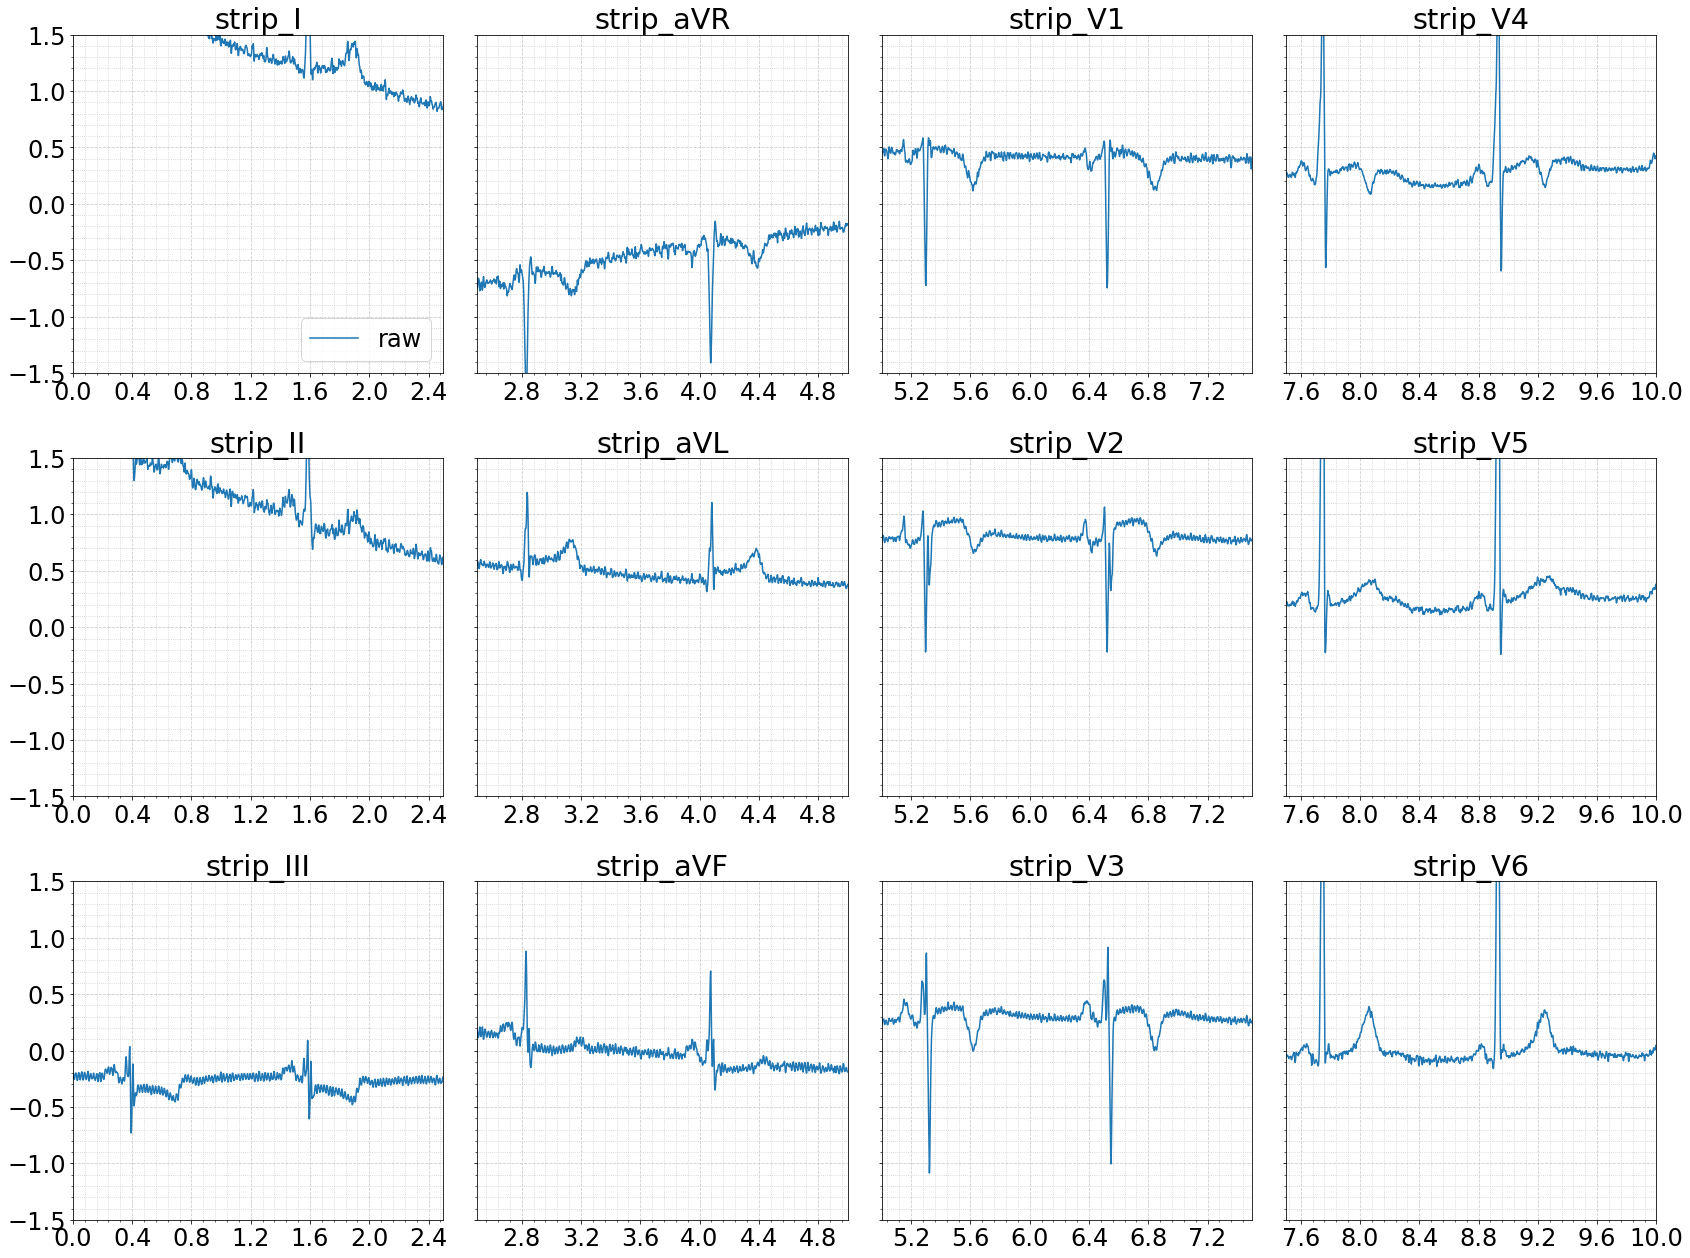

In [10]:
pp = df[df['Sokolow_Lyon']>0.5].iloc[0]
sokolow_lyon_traces = get_ecg_traces(pp['full_path'])
plot_traces(sokolow_lyon_traces)
pp

# Cornell criterion

patient_id                                            5389787.hd5
sex                                                          male
LVH                                                             1
aVL                                                             1
Sokolow_Lyon                                                    0
Cornell                                                         1
full_path              /home/pdiachil/ecg_amp_merged//5389787.hd5
ecg_text        Normal sinus rhythm Left axis deviation Left v...
Name: 1680, dtype: object

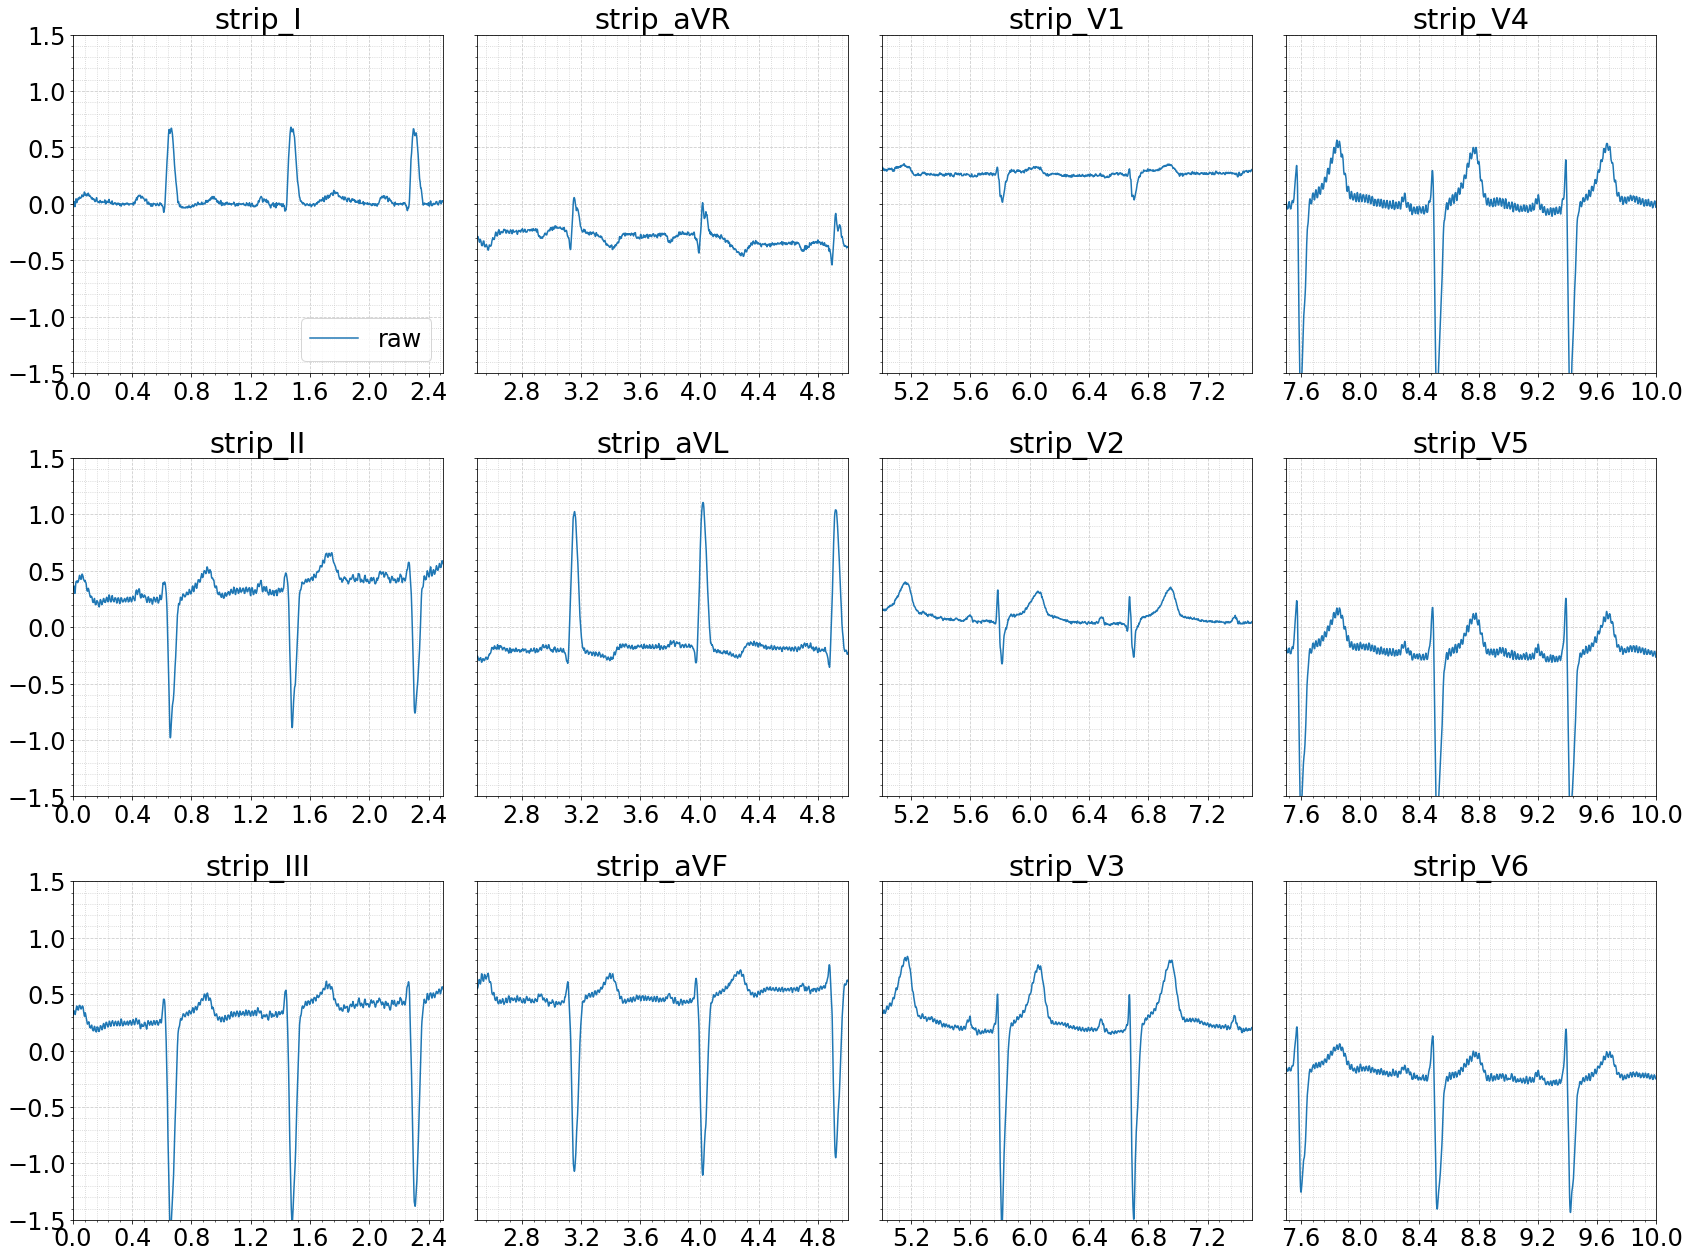

In [14]:
pp = df[df['Cornell']>0.5].iloc[5]
cornell_traces = get_ecg_traces(pp['full_path'])
plot_traces(cornell_traces)
pp

# Control

patient_id                                            2947827.hd5
sex                                                        female
LVH                                                             0
aVL                                                             0
Sokolow_Lyon                                                    0
Cornell                                                         0
full_path              /home/pdiachil/ecg_amp_merged//2947827.hd5
ecg_text        Normal sinus rhythm Possible Left atrial enlar...
Name: 0, dtype: object

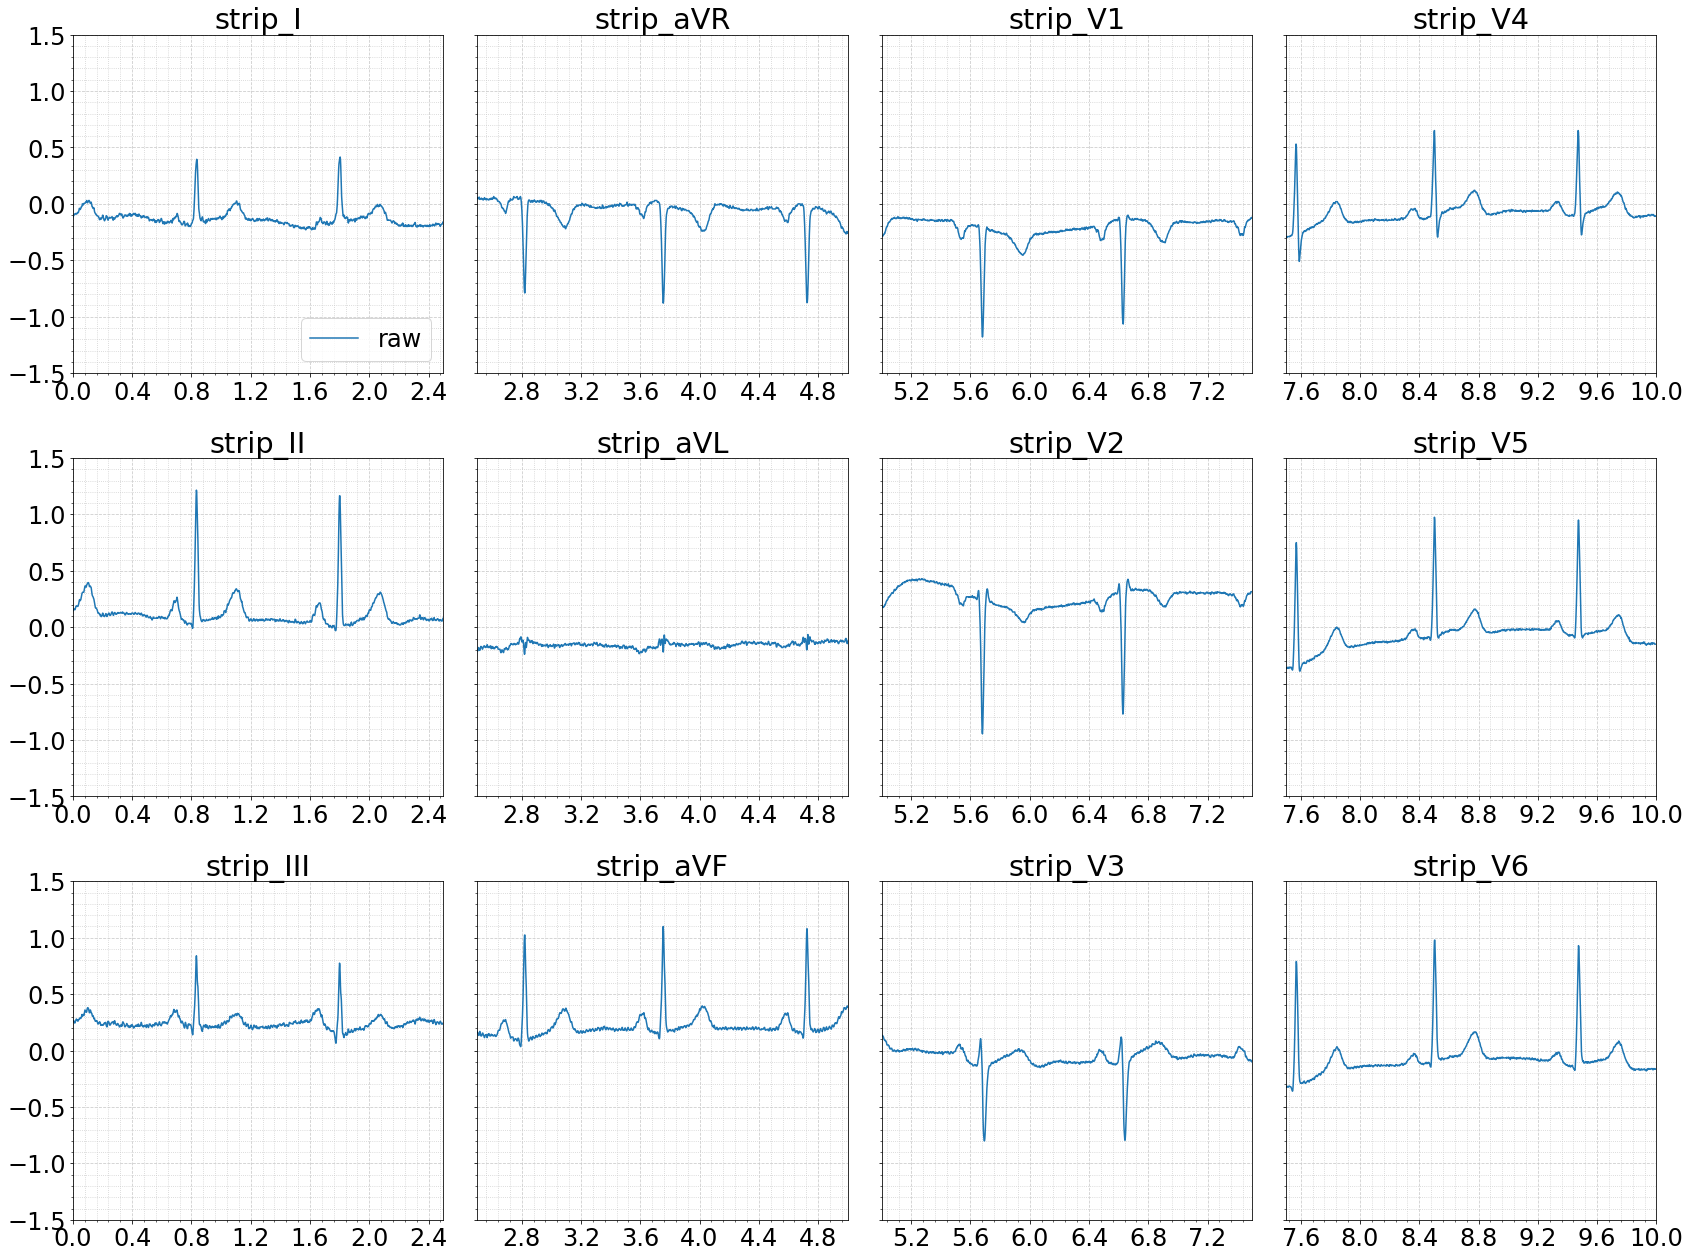

In [12]:
pp = df[df['LVH']<0.5].iloc[0]
cornell_traces = get_ecg_traces(pp['full_path'])
plot_traces(cornell_traces)
pp